## install package

In [5]:
from huggingface_hub import login
login()  # 跳出提示，貼上你的 Token

## dataset prepare

In [26]:
import os, random, hashlib, multiprocessing as mp, psutil
from datasets import load_dataset, Dataset, disable_caching
from datasets import concatenate_datasets

# ---------- CONFIG ----------
DEBUG = True
SEED = 42
SAMPLE_ZH  = 75_000
SAMPLE_SIM = 75_000
MAX_CHARS  = 256  if DEBUG else 512
BUFFER_SIZE = 50_000
BATCH_SIZE  = 5_000
os.environ["HF_ENDPOINT"] = "https://hf-mirror.com"
rng = random.Random(SEED)
disable_caching()

# ---------- HELPERS ----------
def get_optimal_num_proc():
    cpu = mp.cpu_count()
    mem = psutil.virtual_memory().total / 2**30
    return min(8, cpu) if mem >= 16 else min(4, max(2, cpu // 2))

NUM_PROC = get_optimal_num_proc()

def md5_128_vec(texts):
    return [hashlib.md5(t[:128].encode()).hexdigest() for t in texts]

def stream_take(ds_name, split, k):
    return list(
        load_dataset(ds_name, split=split, streaming=True)
        .shuffle(seed=SEED, buffer_size=BUFFER_SIZE)
        .take(k)
    )

# ---------- CONVERT ----------
def convert_batch(batch, mode: str, field: str, _cache={}):
    if not _cache:
        from opencc import OpenCC
        _cache["simp2trad"] = OpenCC("s2twp.json")
        _cache["norm"]      = OpenCC("t2tw.json")

    txt = batch[field]

    if mode == "simp2trad":
        txt = [_cache["simp2trad"].convert(t) for t in txt]

    batch["text"] = [
        _cache["norm"].convert(t).strip().replace("\u3000", "")
        for t in txt
    ]
    return {"text": batch["text"]}  # 僅保留 text；其餘欄位用後續 Dataset API 處理

# ---------- 資料來源 ----------
sources = [
    {"name": "voidful/fineweb-zhtw", "split": "train",
     "sample": SAMPLE_ZH,  "mode": "trad",       "label": 1, "field": "text"},
    {"name": "BAAI/CCI2-Data",       "split": "cci2",
     "sample": SAMPLE_SIM, "mode": "simp2trad", "label": 0, "field": "content"},
]

datasets_list = []
for src in sources:
    raw = stream_take(src["name"], src["split"], src["sample"])
    ds  = (
        Dataset.from_list(raw)
        .map(
            convert_batch,
            fn_kwargs={"mode": src["mode"], "field": src["field"]},
            batched=True, batch_size=BATCH_SIZE, num_proc=NUM_PROC
        )
        .filter(lambda ex: len(ex["text"]) >= 10)
        .add_column("label", [src["label"]] * src["sample"])
    )
    datasets_list.append(ds)

# ---------- 合併 & 去重 ----------
# ---------- 雜湊欄位 ----------
def add_hash(batch):
    import hashlib
    return {
        "hash": [hashlib.md5(t[:128].encode()).hexdigest()  # 128-chars 前綴雜湊
                 for t in batch["text"]]
    }

# ---------- 去重輔助 ----------
def filter_unique(batch, seen=set()):
    flags = []
    for h in batch["hash"]:
        if h in seen:
            flags.append(False)
        else:
            seen.add(h)
            flags.append(True)
    return {"keep": flags}

# ---------- 合併 & 去重 ----------
from datasets import concatenate_datasets
full_ds = concatenate_datasets(datasets_list)

full_ds = (
    full_ds.map(add_hash, batched=True, batch_size=BATCH_SIZE, num_proc=NUM_PROC)
           .map(filter_unique, batched=True, batch_size=BATCH_SIZE, num_proc=1)  # 單進程避免多重 state
           .filter(lambda ex: ex["keep"])
           .remove_columns(["hash", "keep"])
           .shuffle(seed=SEED)
)

# ---------- 資料保存 ----------
os.makedirs("data_cache", exist_ok=True)
out = f"data_cache/fineweb_mix_{len(full_ds)}.parquet"
if not os.path.exists(out):
    full_ds.to_parquet(out, compression="zstd")
    print(f"已儲存 {out}")

if DEBUG:
    lens = [len(t) for t in full_ds["text"]]
    pct  = sum(l >= MAX_CHARS for l in lens) / len(lens)
    print(f"總樣本 {len(full_ds)}，長度≧{MAX_CHARS} 佔 {pct:.2%}")


Resolving data files:   0%|          | 0/322 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/322 [00:00<?, ?it/s]

Map (num_proc=4):   0%|          | 0/75000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/75000 [00:00<?, ? examples/s]

Flattening the indices:   0%|          | 0/75000 [00:00<?, ? examples/s]

Resolving data files:   0%|          | 0/178 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/178 [00:00<?, ?it/s]

Map (num_proc=4):   0%|          | 0/75000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/75000 [00:00<?, ? examples/s]

Flattening the indices:   0%|          | 0/75000 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/150000 [00:00<?, ? examples/s]

Map:   0%|          | 0/150000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/150000 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/150 [00:00<?, ?ba/s]

已儲存 data_cache/fineweb_mix_149215.parquet
總樣本 149215，長度≧256 佔 93.30%


In [28]:
full_ds.push_to_hub(
    repo_id="renhehuang/simp-trad-dataset-149215",
    # create_pr= False,           # 如果想直接推，不開 PR
    private=False,               # 設為公用；要做私用可設 True，但需付費
)

Uploading the dataset shards:   0%|          | 0/2 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/75 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/75 [00:00<?, ?ba/s]

CommitInfo(commit_url='https://huggingface.co/datasets/renhehuang/simp-trad-dataset-149215/commit/0dc3bc9d5d5d59000dd3410ebb0d90cb06480cc3', commit_message='Upload dataset', commit_description='', oid='0dc3bc9d5d5d59000dd3410ebb0d90cb06480cc3', pr_url=None, repo_url=RepoUrl('https://huggingface.co/datasets/renhehuang/simp-trad-dataset-149215', endpoint='https://huggingface.co', repo_type='dataset', repo_id='renhehuang/simp-trad-dataset-149215'), pr_revision=None, pr_num=None)

In [2]:
from datasets import load_dataset

# Login using e.g. `huggingface-cli login` to access this dataset
full_ds = load_dataset("renhehuang/simp-trad-dataset-149215")

README.md:   0%|          | 0.00/871 [00:00<?, ?B/s]

c:\Users\ASUS\miniconda3\envs\VPPM\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\ASUS\.cache\huggingface\hub\datasets--renhehuang--simp-trad-dataset-149215. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


train-00000-of-00002.parquet:   0%|          | 0.00/230M [00:00<?, ?B/s]

train-00001-of-00002.parquet:   0%|          | 0.00/231M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/149215 [00:00<?, ? examples/s]

In [4]:
full_ds

DatasetDict({
    train: Dataset({
        features: ['text', 'id', 'metadata', 'label', 'content'],
        num_rows: 149215
    })
})

## EDA

In [9]:
import pandas as pd
import re
import opencc

# ---- 參數 ----
MIN_LEN = 10
MIN_ZH_RATIO = 0.3
TRADITIONAL_LABEL = 1  # 繁體

# ---- 初始 ----
df = pd.DataFrame({
    "text": full_ds['train']['text'],
    "label": full_ds["train"]["label"]
})
converter = opencc.OpenCC('t2s.json')  # 繁→簡，方便比對差異

# ---- 特徵分析 ----
def zh_ratio(text):
    zh = re.findall(r'[\u4e00-\u9fff]', text)
    return len(zh) / max(len(text), 1)

def has_weird_char(text):
    return bool(re.search(r'[^a-zA-Z0-9\u4e00-\u9fff\s.,!?！？。，「」%％：:\-／/~@#（）()《》<>]', text))

def trad_to_simp_diff_ratio(text):
    simplified = converter.convert(text)
    diff = sum(1 for a, b in zip(text, simplified) if a != b)
    return diff / max(len(text), 1)

# ---- 檢查 ----
df['text_len'] = df['text'].apply(len)
df['zh_ratio'] = df['text'].apply(zh_ratio)
df['weird'] = df['text'].apply(has_weird_char)
df['ts_diff'] = df['text'].apply(trad_to_simp_diff_ratio)

# ---- 標記可疑樣本 ----
df['problem'] = ''
df.loc[df['text_len'] < MIN_LEN, 'problem'] += '[短句]'
df.loc[df['zh_ratio'] < MIN_ZH_RATIO, 'problem'] += '[中文比例低]'
df.loc[df['weird'], 'problem'] += '[含特殊符號]'
df.loc[(df['label'] == TRADITIONAL_LABEL) & (df['ts_diff'] < 0.1), 'problem'] += '[疑似簡體]'

# ---- 顯示問題樣本 ----
problem_df = df[df['problem'] != '']
print(f"發現 {len(problem_df)} 筆潛在有問題的樣本（共 {len(df)} 筆）")
display(problem_df[['text', 'label', 'problem']].head(20))  # 顯示前 20 筆


發現 138160 筆潛在有問題的樣本（共 149215 筆）


,text,label,problem
0,【摩爾認證】明年8月起鋰電池需CCC認證\n按照《國務院辦公廳關於深化電子電器行業管理制度改...,0,[含特殊符號]
1,全國網信辦主任會議在京召開\n1月4日至5日，全國網信辦主任會議在京召開。會議以習近平新時代...,0,[含特殊符號]
2,所有地區的銷量均錄得顯著增長，尤以亞太區、美國及中東最為出色。年內，勞斯萊斯汽車的最大市場依...,1,[含特殊符號]
3,（據山西省人民政府網 11月24日）\n 國有資本不斷向能源革命方向進軍、向新興產業方向集...,0,[含特殊符號]
4,愛肯拿減肥犬低卡路里飼料針對肥胖狗體重控制需求設計，採低卡路里、低碳水化合物及低脂肪原則，增...,1,[含特殊符號]
5,26歲剛懷大寶的時候，我倒是沒有孕吐的反應，但是我的身材也是完全走樣了，而且因為孕激素的分泌...,0,[含特殊符號]
6,在很多徵地拆遷活動中，拆遷戶處於弱勢的地位，以拆遷補償安置方式來說，實踐中，有的徵收方十分強...,0,[含特殊符號]
7,天地間最能讓人感覺欣喜，感到充滿希望的事，就是生命的降臨。\n而誕生除了是一種喜悅、一種開端...,1,[含特殊符號]
8,桃園游姓民眾昨日下午外出，行經中壢區中大一路一處產業道路，在狹小的道路上，對面迎來一輛機車，...,1,[含特殊符號]
9,便秘既是一種獨立的病證，引起便秘的原因分兩種。一可能是急慢性疾病過程中經常出現的症狀，這類因...,0,[含特殊符號]


C:\Users\ASUS\AppData\Local\Temp\ipykernel_20292\3818124491.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(problem_counts.keys()), y=list(problem_counts.values()), palette="Reds_d")


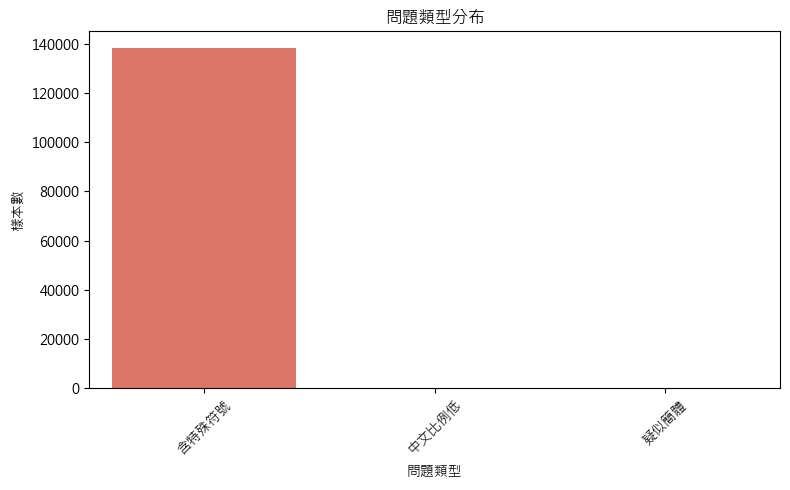

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import re


# 設定 matplotlib 預設字體
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Microsoft JhengHei'  # 換成你電腦有的字型
plt.rcParams['axes.unicode_minus'] = False

# 將 problem 欄位中多標籤拆開，例如 "[短句][疑似簡體]" -> ['短句', '疑似簡體']
def extract_problems(s):
    return re.findall(r'\[(.*?)\]', s)

# 展開所有問題類型
problem_series = df[df['problem'] != '']['problem'].apply(extract_problems)
flat_problems = [p for sublist in problem_series for p in sublist]
problem_counts = Counter(flat_problems)

# 畫圖
plt.figure(figsize=(8, 5))
sns.barplot(x=list(problem_counts.keys()), y=list(problem_counts.values()), palette="Reds_d")
plt.title("問題類型分布")
plt.ylabel("樣本數")
plt.xlabel("問題類型")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [11]:
suspect_simp_df = df[df['problem'].str.contains("疑似簡體")]

display_cols = ['text', 'label', 'problem', 'text_len', 'zh_ratio', 'ts_diff']
display(suspect_simp_df[display_cols].head(20))
print(f"疑似簡體樣本數: {len(suspect_simp_df)}")


,text,label,problem,text_len,zh_ratio,ts_diff
855,4feed her all mouth2:05\n照著字面上解釋， feed her all...,1,[含特殊符號][疑似簡體],687,0.355167,0.094614
961,日本知名玩具品牌壽屋（KOTOBUKIYA）公司又將在旗下ARTFX+ Statue 雕像產...,1,[含特殊符號][疑似簡體],498,0.534137,0.098394
2464,"Sr. POLLI, Rosa FDCC\n羅撒波里修女\n\n\n* 1882 年 2\n...",1,[中文比例低][含特殊符號][疑似簡體],1672,0.153110,0.037081
3127,我們不支持您使用的這種瀏覽器。TripAdvisor網站可能不能正常顯示。\n我們支持以下瀏...,1,[含特殊符號][疑似簡體],336,0.330357,0.098214
3429,"Breezy Dream™\nLinux, Android, Free Software a...",1,[含特殊符號][疑似簡體],353,0.399433,0.099150
3784,原：一傢三代患精神疾病 傢：何不能制收容？\n4月1日下午520分，西安小寨泰城口生一起持刀...,1,[含特殊符號][疑似簡體],2034,0.839233,0.064405
4040,Jessica Jones源於2001年由頂盛時期的Brian Michael Bendis...,1,[疑似簡體],347,0.365994,0.095101
5452,4.5.12\nBlackrock Summit Trail是Skyline Drive南段...,1,[含特殊符號][疑似簡體],889,0.380202,0.080990
7387,一月\n12\n2005\n我在 改用WP 裡面有提到過這邊變成我碎碎唸的地方.\n我在這邊...,1,[含特殊符號][疑似簡體],156,0.365385,0.096154
7723,VGL 晚點回 @@ 忽然發現自己其實還滿高興的 XD 所以回去後再說。\n*\n其實大部份...,1,[含特殊符號][疑似簡體],732,0.349727,0.094262


疑似簡體樣本數: 145


In [12]:
suspect_simp_df = df[df['problem'].str.contains("中文比例低")]

display_cols = ['text', 'label', 'problem', 'text_len', 'zh_ratio', 'ts_diff']
display(suspect_simp_df[display_cols].head(20))
print(f"中文比例低樣本數: {len(suspect_simp_df)}")

,text,label,problem,text_len,zh_ratio,ts_diff
386,Forum: 一般討論 (General)\nTopic: 【開坑】Wakana 2020春...,0,[中文比例低][含特殊符號],309,0.268608,0.093851
1438,"Modern摩登衛浴 C-6100 / NO.3 免治馬桶蓋(遙控型)\n星期五, 3月 0...",0,[中文比例低][含特殊符號],127,0.299213,0.086614
2464,"Sr. POLLI, Rosa FDCC\n羅撒波里修女\n\n\n* 1882 年 2\n...",1,[中文比例低][含特殊符號][疑似簡體],1672,0.153110,0.037081
2579,自動攪拌一體車先行者！\n 在操作過程中，請勿對混泥土攪拌車進行維修或潤滑。\n Do no...,0,[中文比例低][含特殊符號],4956,0.274415,0.092413
2987,很抱歉，如果JavaScript沒有啟用，Airbnb網站的某些功能無法正常使用。\n Cr...,0,[中文比例低][含特殊符號],1997,0.074612,0.030546
4199,首頁 > 學會刊物 > 《運動醫學與健康科學》 > 2022年第二期\n《運動醫學與健康科學...,0,[中文比例低][含特殊符號],224,0.209821,0.107143
4221,巴哈馬政府扣押了 FTX 4.77 億美金資產 [src][archive]\nEpic 表...,0,[中文比例低][含特殊符號],312,0.240385,0.054487
4301,by Via.\n 展館是Herzog & de Meuron 和 Ai Weiwei在英國...,0,[中文比例低][含特殊符號],2879,0.166377,0.053491
4371,首頁 › LOUIS VUITTON 微型吊飾 SPEEDY/NOE\nLOUIS VUIT...,0,[中文比例低][含特殊符號],122,0.270492,0.049180
4732,Lectures announcement\n◆專題演講公告◆ 時間：111年5月23日（一...,0,[中文比例低][含特殊符號],312,0.230769,0.076923


中文比例低樣本數: 340


## Data Cleaning

In [13]:
import pandas as pd
import re
import opencc

# ---- 參數設定 ----
MIN_LEN = 10
MIN_ZH_RATIO = 0.3
TRADITIONAL_LABEL = 1  # 繁體
WEIRD_CHAR_PATTERN = r'[^a-zA-Z0-9\u4e00-\u9fff\s\.\,\!\?！？。，「」％%：:\-／/~@#\(\)《》<>]'

# ---- 載入資料 ----
converter = opencc.OpenCC('t2s.json')  # 繁→簡，用於計算差異比例

# ---- 定義輔助函式 ----
def zh_ratio(text: str) -> float:
    """計算文字中中文佔比"""
    zh = re.findall(r'[\u4e00-\u9fff]', text)
    return len(zh) / max(len(text), 1)

def trad_to_simp_diff_ratio(text: str) -> float:
    """將繁體轉為簡體後，比對原文與簡體的字符差異比例"""
    simplified = converter.convert(text)
    diff = sum(1 for a, b in zip(text, simplified) if a != b)
    return diff / max(len(text), 1)

def remove_special_chars(text: str) -> str:
    """
    去除所有不在允許清單中的特殊符號
    允許清單：中英文、數字、常見標點符號與空格
    """
    return re.sub(WEIRD_CHAR_PATTERN, '', text)

# ---- 第一步：移除特殊符號 ----
df['text'] = df['text'].apply(remove_special_chars)

# ---- 第二步：重新計算特徵 ----
df['text_len'] = df['text'].apply(len)
df['zh_ratio'] = df['text'].apply(zh_ratio)
df['ts_diff'] = df['text'].apply(trad_to_simp_diff_ratio)

# ---- 第三步：篩選／刪除不符合條件的樣本 ----
# 條件1：文字長度必須 >= MIN_LEN
cond_len = df['text_len'] >= MIN_LEN

# 條件2：中文比例必須 >= MIN_ZH_RATIO
cond_zh = df['zh_ratio'] >= MIN_ZH_RATIO

# 條件3：對於標記為繁體的，繁簡差異比例必須 >= 0.1（否則疑似簡體，視為問題資料）
cond_ts = ~((df['label'] == TRADITIONAL_LABEL) & (df['ts_diff'] < 0.1))

# 保留符合所有條件的資料
df_clean = df[cond_len & cond_zh & cond_ts].reset_index(drop=True)

# ---- 選擇要保留的欄位 ----
df_clean = df_clean[['text', 'label']]

# ---- 顯示清洗後結果 ----
print(f"原始資料共 {len(df)} 筆，清洗後保留 {len(df_clean)} 筆")


原始資料共 149215 筆，清洗後保留 148797 筆


In [15]:
from datasets import load_dataset, Dataset, disable_caching
dataset = Dataset.from_pandas(df_clean[["text", "label"]])

## tokenizer

In [16]:
from datasets import load_dataset

import multiprocessing as mp


NUM_PROC  = mp.cpu_count()  # 或你實際計算的最佳值
# 1. 檢查原始欄位
print(full_ds.column_names)
# 例：['text', 'label', 'id', 'source']

# 2. 定義 tokenize_fn（只回傳 3 個欄位）
def tokenize_fn(examples):
    from transformers import AutoTokenizer
    tokenizer = AutoTokenizer.from_pretrained("ckiplab/bert-base-chinese")
    texts = examples["text"]
    labs  = examples["label"]

    input_ids_batch = []
    attn_mask_batch = []
    label_batch     = []

    for text, lab in zip(texts, labs):
        if len(text) <= 256:
            out = tokenizer(
                text,
                truncation=True,
                max_length=256,
                return_attention_mask=True,
                return_token_type_ids=False,
                padding=False
            )
            input_ids_batch.append(out["input_ids"])
            attn_mask_batch.append(out["attention_mask"])
            label_batch.append(lab)
        else:
            out = tokenizer(
                text,
                truncation=True,
                max_length=256,
                stride=128,
                return_overflowing_tokens=True,
                return_attention_mask=True,
                return_token_type_ids=False,
                padding=False
            )
            mapping = out.pop("overflow_to_sample_mapping")
            chunk_labels = [lab] * len(mapping)

            input_ids_batch.extend(out["input_ids"])
            attn_mask_batch.extend(out["attention_mask"])
            label_batch.extend(chunk_labels)

    return {
        "input_ids": input_ids_batch,
        "attention_mask": attn_mask_batch,
        "labels": label_batch
    }

# 3. map 時移除所有原始欄位
encoded_dataset = full_ds.map(
    tokenize_fn,
    batched=True,
    batch_size=512,
    num_proc=NUM_PROC,
    remove_columns=['text', 'id', 'metadata', 'label', 'content']
)

# 4. 最後確認新欄位
print(encoded_dataset.column_names)
# 預期： ['input_ids', 'attention_mask', 'labels']


{'train': ['text', 'id', 'metadata', 'label', 'content']}


Map (num_proc=16):   0%|          | 0/149215 [00:00<?, ? examples/s]

{'train': ['input_ids', 'attention_mask', 'labels']}


## Finetune

In [ ]:
# 先卸掉舊版
!pip uninstall -y torch torchvision torchaudio

# 安裝對應 CUDA 12.1 的最新 PyTorch
!pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu128

Found existing installation: torch 2.5.1+cu121
Uninstalling torch-2.5.1+cu121:
  Successfully uninstalled torch-2.5.1+cu121
Found existing installation: torchvision 0.20.1+cu121
Uninstalling torchvision-0.20.1+cu121:
  Successfully uninstalled torchvision-0.20.1+cu121
Found existing installation: torchaudio 2.5.1+cu121
Uninstalling torchaudio-2.5.1+cu121:
  Successfully uninstalled torchaudio-2.5.1+cu121


You can safely remove it manually.


^C


ERROR: Exception:
Traceback (most recent call last):
  File "C:\Users\ASUS\miniconda3\envs\VPPM\Lib\site-packages\pip\_vendor\urllib3\response.py", line 438, in _error_catcher
    yield
  File "C:\Users\ASUS\miniconda3\envs\VPPM\Lib\site-packages\pip\_vendor\urllib3\response.py", line 561, in read
    data = self._fp_read(amt) if not fp_closed else b""
           ^^^^^^^^^^^^^^^^^^
  File "C:\Users\ASUS\miniconda3\envs\VPPM\Lib\site-packages\pip\_vendor\urllib3\response.py", line 527, in _fp_read
    return self._fp.read(amt) if amt is not None else self._fp.read()
           ^^^^^^^^^^^^^^^^^^
  File "C:\Users\ASUS\miniconda3\envs\VPPM\Lib\site-packages\pip\_vendor\cachecontrol\filewrapper.py", line 98, in read
    data: bytes = self.__fp.read(amt)
                  ^^^^^^^^^^^^^^^^^^^
  File "C:\Users\ASUS\miniconda3\envs\VPPM\Lib\http\client.py", line 473, in read
    s = self.fp.read(amt)
        ^^^^^^^^^^^^^^^^^
  File "C:\Users\ASUS\miniconda3\envs\VPPM\Lib\socket.py", line 718,

Looking in indexes: https://download.pytorch.org/whl/cu128
   ---------------------------------------- 0.0/3.3 GB ? eta -:--:--
   ---------------------------------------- 0.0/3.3 GB ? eta -:--:--
   ---------------------------------------- 0.0/3.3 GB ? eta -:--:--
   ---------------------------------------- 0.0/3.3 GB ? eta -:--:--
   ---------------------------------------- 0.0/3.3 GB ? eta -:--:--
   ---------------------------------------- 0.0/3.3 GB ? eta -:--:--
   ---------------------------------------- 0.0/3.3 GB ? eta -:--:--
   ---------------------------------------- 0.0/3.3 GB 429.7 kB/s eta 2:09:27
   ---------------------------------------- 0.0/3.3 GB 429.7 kB/s eta 2:09:27
   ---------------------------------------- 0.0/3.3 GB 541.1 kB/s eta 1:42:49
   ---------------------------------------- 0.0/3.3 GB 541.1 kB/s eta 1:42:49
   ---------------------------------------- 0.0/3.3 GB 524.3 kB/s eta 1:46:06
   ---------------------------------------- 0.0/3.3 GB 524.3 kB/s et

In [1]:
import torch
print("Torch version:  ", torch.__version__)        # 確保 ≥ 2.6.0
print("CUDA support:  ", torch.version.cuda)        # 例如 '12.1'
print("CUDA Enabled:  ", torch.cuda.is_available()) # 必須為 True
if torch.cuda.is_available():
    print("GPU Name:     ", torch.cuda.get_device_name(0))

Torch version:   2.5.1+cu121
CUDA support:   12.1
CUDA Enabled:   True
GPU Name:      NVIDIA GeForce RTX 3060 Laptop GPU


In [17]:
labels = set(dataset["label"])
print("所有 label:", labels)
print("最大:", max(labels), "最小:", min(labels))

所有 label: {0, 1}
最大: 1 最小: 0


In [19]:
# 假設經過 tokenize 與去重後，原本是
# encoded_dataset = DatasetDict({"train": Dataset(...)})
print("原始 encoded_dataset keys:", encoded_dataset.keys())
# -> dict_keys(['train'])

# 1. 再把唯一的 train 拆成 train+validation
split = encoded_dataset["train"].train_test_split(test_size=0.1, seed=42)

# 2. 建立新的 DatasetDict
dataset_dict = DatasetDict({
    "train": split["train"],
    "validation": split["test"]
})

print("拆分後 dataset_dict keys:", dataset_dict.keys())
# -> dict_keys(['train', 'validation'])

原始 encoded_dataset keys: dict_keys(['train'])
拆分後 dataset_dict keys: dict_keys(['train', 'validation'])


In [23]:
import math
import wandb
from datasets import DatasetDict
from transformers import (
    AutoModelForSequenceClassification,
    AutoTokenizer,
    Trainer,
    TrainingArguments
)

# 2. 初始化 W&B（如之前示範）
wandb.init(
    project="my-bert-chinese-project",
    name="bert-classification-run1",
    save_code=True,
)

# 3. 載入 tokenizer 與 model
tokenizer = AutoTokenizer.from_pretrained(
    "ckiplab/bert-base-chinese",
    cache_dir="./hf_cache",
    use_fast=True
)
model = AutoModelForSequenceClassification.from_pretrained(
    "ckiplab/bert-base-chinese",
    num_labels=3,
    hidden_dropout_prob=0.3,
    torch_dtype="auto",
    gradient_checkpointing=True
)

# 4. 計算步數
per_device_train_batch_size = 16
gradient_accumulation_steps  = 2
num_train_samples           = len(dataset_dict["train"])
num_epochs                  = 3

steps_per_epoch = math.ceil(
    num_train_samples /
    (per_device_train_batch_size * gradient_accumulation_steps)
)
total_training_steps = steps_per_epoch * num_epochs
warmup_steps = int(0.1 * total_training_steps)

# 5. 設定 TrainingArguments
training_args = TrainingArguments(
    output_dir="./model_ckpt",
    overwrite_output_dir=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,

    per_device_train_batch_size=per_device_train_batch_size,
    per_device_eval_batch_size=per_device_train_batch_size * 2,
    gradient_accumulation_steps=gradient_accumulation_steps,
    num_train_epochs=num_epochs,

    learning_rate=2e-5,
    warmup_steps=warmup_steps,
    weight_decay=0.01,

    logging_strategy="steps",
    logging_steps=max(1, steps_per_epoch // 10),
    fp16=True,
    seed=42,

    dataloader_num_workers=4,
    disable_tqdm=False,
    report_to="wandb"
)

# 6. 建立 Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset_dict["train"],
    eval_dataset=dataset_dict["validation"],
    tokenizer=tokenizer
)

# 7. 開始訓練
trainer.train()

# 8. 結束 W&B
wandb.finish()


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


ValueError: Due to a serious vulnerability issue in `torch.load`, even with `weights_only=True`, we now require users to upgrade torch to at least v2.6 in order to use the function. This version restriction does not apply when loading files with safetensors.
See the vulnerability report here https://nvd.nist.gov/vuln/detail/CVE-2025-32434

In [ ]:
model.save_pretrained("./bert-zh-tw-classifier")
tokenizer.save_pretrained("./bert-zh-tw-classifier")

('./bert-zh-tw-classifier\\tokenizer_config.json',
 './bert-zh-tw-classifier\\special_tokens_map.json',
 './bert-zh-tw-classifier\\vocab.txt',
 './bert-zh-tw-classifier\\added_tokens.json',
 './bert-zh-tw-classifier\\tokenizer.json')

In [ ]:
trainer.save_model("./model_ckpt")  # 這會同時儲存 model 和 config.json
tokenizer.save_pretrained("./model_ckpt")


('./model_ckpt\\tokenizer_config.json',
 './model_ckpt\\special_tokens_map.json',
 './model_ckpt\\vocab.txt',
 './model_ckpt\\added_tokens.json',
 './model_ckpt\\tokenizer.json')

In [ ]:
from transformers import pipeline, AutoModelForSequenceClassification, AutoTokenizer

classifier = pipeline("text-classification", model="./model_ckpt", tokenizer="./model_ckpt")
classifier("欢迎来到台灣")


Device set to use cuda:0


[{'label': 'LABEL_2', 'score': 0.9333289265632629}]

In [ ]:
results = trainer.evaluate()
print(results)

{'eval_loss': 0.13141664862632751, 'eval_runtime': 243.8417, 'eval_samples_per_second': 469.555, 'eval_steps_per_second': 7.341, 'epoch': 2.999650667225599}


In [ ]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
from transformers import Trainer, TrainingArguments

# 1. 準備 test dataset（假設叫 encoded_dataset["validation"]，你也可替換為 test set）
eval_dataset = encoded_dataset["validation"]

# 2. 用 Trainer 進行預測
preds_output = trainer.predict(eval_dataset)
y_true = preds_output.label_ids
y_pred = np.argmax(preds_output.predictions, axis=1)

# 3. 計算 classification report
target_names = ["簡體", "繁體", "混合"]
report = classification_report(y_true, y_pred, target_names=target_names, digits=4)
print("=== Classification Report ===")
print(report)


=== Classification Report ===
              precision    recall  f1-score   support

          簡體     0.9991    0.9998    0.9994     59781
          繁體     0.8420    0.9916    0.9107     31729
          混合     0.9848    0.7415    0.8460     22987

    accuracy                         0.9456    114497
   macro avg     0.9420    0.9109    0.9187    114497
weighted avg     0.9527    0.9456    0.9440    114497



=== Confusion Matrix ===
[[59767     5     9]
 [   12 31463   254]
 [   42  5901 17044]]


c:\Users\ASUS\miniconda3\envs\VPPM\Lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 31777 (\N{CJK UNIFIED IDEOGRAPH-7C21}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
c:\Users\ASUS\miniconda3\envs\VPPM\Lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 39636 (\N{CJK UNIFIED IDEOGRAPH-9AD4}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
c:\Users\ASUS\miniconda3\envs\VPPM\Lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 32321 (\N{CJK UNIFIED IDEOGRAPH-7E41}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
c:\Users\ASUS\miniconda3\envs\VPPM\Lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 28151 (\N{CJK UNIFIED IDEOGRAPH-6DF7}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
c:\Users\ASUS\miniconda3\envs\VPPM\Lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 21512 (\N{CJK UNIFIED IDEOGRAPH-5408}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
c:\Users\ASUS\miniconda3\envs\VPPM\Lib\site-packages\IPython\core\pyla

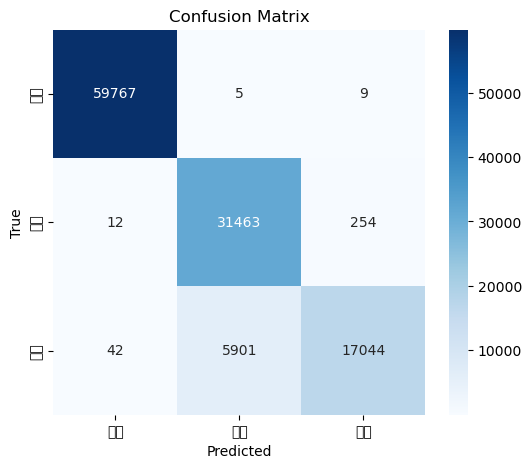

In [ ]:
# 混淆矩陣
cm = confusion_matrix(y_true, y_pred)
print("=== Confusion Matrix ===")
print(cm)

# 若需視覺化（需要 matplotlib）
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


⚠️ 未找到合適中文字型，請手動下載並設置 font_path。


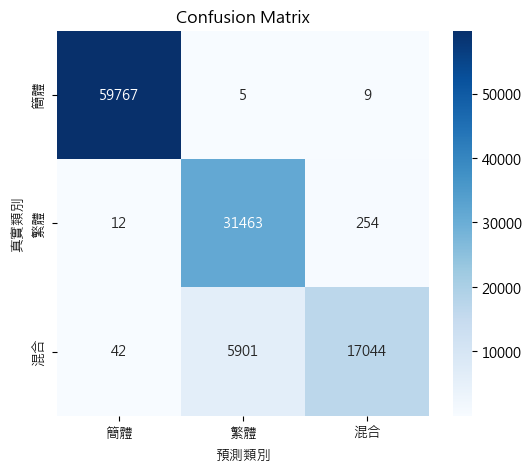

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import font_manager

# 1. 設定中文字型（自動尋找系統字型，常見有「SimHei」「Noto Sans CJK」「Microsoft JhengHei」）
font_path = ""
for candidate in ['NotoSansCJK-TC-Regular.otf', 'SimHei.ttf', 'Microsoft JhengHei.ttf']:
    fonts = font_manager.findSystemFonts(fontpaths=None, fontext='ttf')
    for f in fonts:
        if candidate in f:
            font_path = f
            break
    if font_path:
        break

if not font_path:
    print("⚠️ 未找到合適中文字型，請手動下載並設置 font_path。")

plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei', 'Noto Sans CJK TC', 'SimHei']
plt.rcParams['axes.unicode_minus'] = False

# 2. 繪製 confusion matrix
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['簡體', '繁體', '混合'], 
            yticklabels=['簡體', '繁體', '混合'])
plt.xlabel('預測類別')
plt.ylabel('真實類別')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
import pandas as pd

df_check = pd.DataFrame({
    'true': y_true,
    'pred': y_pred
})

# 各類預測與真實分布
print("=== 預測類別分布 ===")
print(df_check['pred'].value_counts().sort_index())

print("=== 真實類別分布 ===")
print(df_check['true'].value_counts().sort_index())

# 檢查系統性誤判：真實為某一類但常被預測為另一類
for true_label in range(3):
    misclassified = df_check[(df_check['true'] == true_label) & (df_check['pred'] != true_label)]
    print(f"--- 真實類別 {target_names[true_label]} 被誤判分布 ---")
    print(misclassified['pred'].value_counts())


=== 預測類別分布 ===
pred
0    59821
1    37369
2    17307
Name: count, dtype: int64
=== 真實類別分布 ===
true
0    59781
1    31729
2    22987
Name: count, dtype: int64
--- 真實類別 簡體 被誤判分布 ---
pred
2    9
1    5
Name: count, dtype: int64
--- 真實類別 繁體 被誤判分布 ---
pred
2    254
0     12
Name: count, dtype: int64
--- 真實類別 混合 被誤判分布 ---
pred
1    5901
0      42
Name: count, dtype: int64


## PUSH

In [ ]:
from huggingface_hub import notebook_login

notebook_login()


In [ ]:
from transformers import AutoTokenizer

# 儲存模型與 tokenizer
model.save_pretrained("./model_ckpt")
tokenizer.save_pretrained("./model_ckpt")

# 推送到 Hugging Face
from huggingface_hub import HfApi, create_repo, upload_folder

# repo_id 建議格式："username/model-name"
repo_id = "renhehuang/bert-base-chinese-traditional-classifier-v3"
create_repo(repo_id, private=False)  # 若要私有改成 private=True

# 將整個資料夾上傳
upload_folder(
    folder_path="./model_ckpt",
    repo_id=repo_id,
    commit_message="Initial commit"
)


model.safetensors:   0%|          | 0.00/409M [00:00<?, ?B/s]

scaler.pt:   0%|          | 0.00/988 [00:00<?, ?B/s]

rng_state.pth:   0%|          | 0.00/14.2k [00:00<?, ?B/s]

optimizer.pt:   0%|          | 0.00/818M [00:00<?, ?B/s]

scheduler.pt:   0%|          | 0.00/1.06k [00:00<?, ?B/s]

Upload 14 LFS files:   0%|          | 0/14 [00:00<?, ?it/s]

training_args.bin:   0%|          | 0.00/5.30k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/409M [00:00<?, ?B/s]

optimizer.pt:   0%|          | 0.00/818M [00:00<?, ?B/s]

rng_state.pth:   0%|          | 0.00/14.2k [00:00<?, ?B/s]

scaler.pt:   0%|          | 0.00/988 [00:00<?, ?B/s]

scheduler.pt:   0%|          | 0.00/1.06k [00:00<?, ?B/s]

training_args.bin:   0%|          | 0.00/5.30k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/409M [00:00<?, ?B/s]

training_args.bin:   0%|          | 0.00/5.30k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/renhehuang/bert-base-chinese-traditional-classifier-v3/commit/24e0df7fc153c72e21922bdb8c0052cba9efd13b', commit_message='Initial commit', commit_description='', oid='24e0df7fc153c72e21922bdb8c0052cba9efd13b', pr_url=None, repo_url=RepoUrl('https://huggingface.co/renhehuang/bert-base-chinese-traditional-classifier-v3', endpoint='https://huggingface.co', repo_type='model', repo_id='renhehuang/bert-base-chinese-traditional-classifier-v3'), pr_revision=None, pr_num=None)

## test

In [ ]:
import random
import pandas as pd

trad_samples = [
    "這是一個繁體中文的測試句子。", "歡迎來到台灣！", "請問您需要什麼協助？",
    "我們今天學習了很多知識。", "天氣很好，適合出門散步。", "你喜歡吃什麼台灣小吃？",
    "這本書很有趣，推薦你看看。", "捷運系統非常方便。", "週末一起去看電影好嗎？", "我在圖書館讀書。"
]
simp_samples = [
    "这是一个简体中文的测试句子。", "欢迎来到中国！", "请问您需要什么帮助？",
    "我们今天学到了很多知识。", "天气很好，适合出去散步。", "你喜欢吃什么中国小吃？",
    "这本书很有趣，推荐你看看。", "地铁系统非常方便。", "周末一起去看电影好吗？", "我在图书馆学习。"
]

def random_samples(source, n):
    return [random.choice(source) for _ in range(n)]

def mixed_samples(trad_source, simp_source, n, trad_ratio):
    n_trad = int(n * trad_ratio)
    n_simp = n - n_trad
    return random_samples(trad_source, n_trad) + random_samples(simp_source, n_simp)

trad_data = random_samples(trad_samples, 50)
simp_data = random_samples(simp_samples, 50)
mix1_data = mixed_samples(trad_samples, simp_samples, 50, trad_ratio=0.7)
random.shuffle(mix1_data)
mix2_data = mixed_samples(trad_samples, simp_samples, 50, trad_ratio=0.3)
random.shuffle(mix2_data)

test_df = pd.DataFrame({
    "group": ["trad"]*50 + ["simp"]*50 + ["mix1"]*50 + ["mix2"]*50,
    "text": trad_data + simp_data + mix1_data + mix2_data
})


In [ ]:
from transformers import pipeline

classifier = pipeline("text-classification", model="./model_ckpt", tokenizer="./model_ckpt", device=0)  # CUDA
results = [classifier(t)[0] for t in test_df["text"]]
test_df["pred_label"] = [r["label"] for r in results]
test_df["score"] = [r["score"] for r in results]


Device set to use cuda:0
You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


In [ ]:
summary = test_df.groupby("group")["pred_label"].value_counts().unstack(fill_value=0)
print("分類結果分布：")
print(summary)


分類結果分布：
pred_label  LABEL_0  LABEL_1  LABEL_2
group                                
mix1              5       35       10
mix2             10       15       25
simp             17        0       33
trad              0       50        0


In [ ]:
score_stats = test_df.groupby("group")["score"].agg(["mean", "std", "min", "max"])
print("\n信心分數統計：")
print(score_stats)
